In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from utils import LOG_DIR, SPEED_LOG_DIR, GPT_LOG_DIR, FIG_DIR
from typing import Dict

def parse_log_file(file_path):
    # Define the patterns to search for
    peak_activation_memory_pattern = r"Peak Activation Memory: (.+?) Bytes"
    total_memory_pattern = r"Total Memory: (.+?) Bytes"
    avg_forward_time_pattern = r"Average Forward Time: (.+?) sec"
    avg_backward_time_pattern = r"Average Backward Time: (.+?) sec"
    throughput_pattern = r"Throughput: (.+?) samples/sec"
    max_memory_device_pattern = r"(cuda:\d+): (.+?) Bytes"

    # Dictionary to store the extracted information
    data = {
        "peak_activation_memory_mib": None,
        "peak_activation_memory_gib": None,
        "total_memory_mib": None,
        "total_memory_gb": None,
        "average_forward_time_sec": None,
        "average_backward_time_sec": None,
        "throughput_samples_per_sec": None,
        "max_memory_per_device_mib": {},
        "max_memory_per_device_gib": {},
    }

    def convert_data(data_str):
        return ''.join(str(data_str).split(','))
    
    def bytes_to_mib(bytes_str):
        # Convert bytes to MiB
        bytes_str = convert_data(bytes_str)
        return round(int(bytes_str) / (1024**2), 2)
    
    def bytes_to_gib(bytes_str):
        # Convert bytes to GiB
        bytes_str = convert_data(bytes_str)
        return round(int(bytes_str) / (1024**3), 2)

    with open(file_path, 'r') as file:
        for line in file:
            # Check for each pattern and extract data
            if match := re.search(peak_activation_memory_pattern, line):
                data["peak_activation_memory_mib"] = bytes_to_mib(match.group(1))
                data["peak_activation_memory_gib"] = bytes_to_gib(match.group(1))
            elif match := re.search(total_memory_pattern, line):
                data["total_memory_mib"] = bytes_to_mib(match.group(1))
                data["total_memory_gb"] = bytes_to_gib(match.group(1))
            elif match := re.search(avg_forward_time_pattern, line):
                data["average_forward_time_sec"] = float(match.group(1))
            elif match := re.search(avg_backward_time_pattern, line):
                data["average_backward_time_sec"] = float(match.group(1))
            elif match := re.search(throughput_pattern, line):
                data["throughput_samples_per_sec"] = float(match.group(1))
            elif match := re.search(max_memory_device_pattern, line):
                device, memory_bytes = match.groups()
                data["max_memory_per_device_mib"][device] = bytes_to_mib(memory_bytes)
                data["max_memory_per_device_gib"][device] = bytes_to_gib(memory_bytes)

    return data

def print_dict(data: Dict):
    for key, value in data.items():
        print(f"{key}: {value}")


def args_to_exprname(
    num_partition: int,
    num_microbatch: int,
    checkpoint_enabled: bool,
    use_torchgpipe: bool,
    gpt_2: bool=False,
):
    if not gpt_2:
        if num_partition > 0:
            return (f'mem_expr_K{num_partition}_M{num_microbatch}_'
                f'{"check_" if checkpoint_enabled else ""}'
                f'{"torchgpipe" if use_torchgpipe else "self"}'
            )
        else:
            return 'baseline'
    else:
        if num_partition > 0:
            return (f'gpt2_K{num_partition}_M{num_microbatch}_'
                f'{"check_" if checkpoint_enabled else ""}'
                f'{"torchgpipe" if use_torchgpipe else "self"}'
            )
        else:
            return 'gpt2_baseline'

## Memory Experiments
Variables:
- partition plans
- number of microbatches
- checkpointing enabled

### GPT-2

In [2]:
# get all file names under DATA_DIR
expr_data = {}
file_names = os.listdir(GPT_LOG_DIR)
for file_name in file_names:
    if file_name.endswith(".log"):
        file_path = os.path.join(GPT_LOG_DIR, file_name)
        data = parse_log_file(file_path)
        expr_data[file_name[:-4]] = data

num_partitions = [1, 2, 4]
num_micro_batches = [1, 2, 4, 8, 16, 32, 64]
checkpoint_enabled = [True, False]
use_torchgpipe = [True, False]

In [3]:
file_names

['gpt2_K1_M16_self.log',
 'gpt2_K2_M1_check_torchgpipe.log',
 'gpt2_K2_M32_check_self.log',
 'gpt2_K4_M4_self.log',
 'gpt2_K2_M16_self.log',
 'gpt2_K2_M32_torchgpipe.log',
 'gpt2_K4_M4_check_torchgpipe.log',
 'gpt2_K1_M16_check_self.log',
 'gpt2_K4_M1_self.log',
 'gpt2_K1_M4_check_self.log',
 'gpt2_K4_M32_check_torchgpipe.log',
 'gpt2_K1_M1_self.log',
 'gpt2_K2_M64_self.log',
 'gpt2_K2_M32_self.log',
 'gpt2_K2_M2_check_torchgpipe.log',
 'gpt2_K4_M8_torchgpipe.log',
 'gpt2_K1_M16_check_torchgpipe.log',
 'gpt2_K4_M2_check_self.log',
 'gpt2_K2_M1_self.log',
 'gpt2_K1_M64_self.log',
 'gpt2_K4_M64_check_torchgpipe.log',
 'gpt2_K4_M64_torchgpipe.log',
 'gpt2_K2_M1_torchgpipe.log',
 'gpt2_K1_M8_self.log',
 'gpt2_K2_M16_check_self.log',
 'gpt2_K2_M2_torchgpipe.log',
 'gpt2_K4_M16_check_torchgpipe.log',
 'gpt2_K2_M64_check_self.log',
 'gpt2_K1_M32_self.log',
 'gpt2_K4_M8_self.log',
 'gpt2_K1_M64_check_torchgpipe.log',
 'gpt2_K4_M1_check_self.log',
 'gpt2_K2_M8_check_torchgpipe.log',
 'gpt2_K1_M

#### Baseline

In [4]:
expr_name = args_to_exprname(0, 1, False, False, gpt_2=True)
baseline = expr_data[expr_name]

print(expr_name)
print('-' * 20)
print_dict(baseline)

gpt2_baseline
--------------------
peak_activation_memory_mib: 6614.75
peak_activation_memory_gib: 6.46
total_memory_mib: 7642.0
total_memory_gb: 7.46
average_forward_time_sec: 0.06
average_backward_time_sec: 0.041
throughput_samples_per_sec: 634.796
max_memory_per_device_mib: {'cuda:0': 7642.0}
max_memory_per_device_gib: {'cuda:0': 7.46}


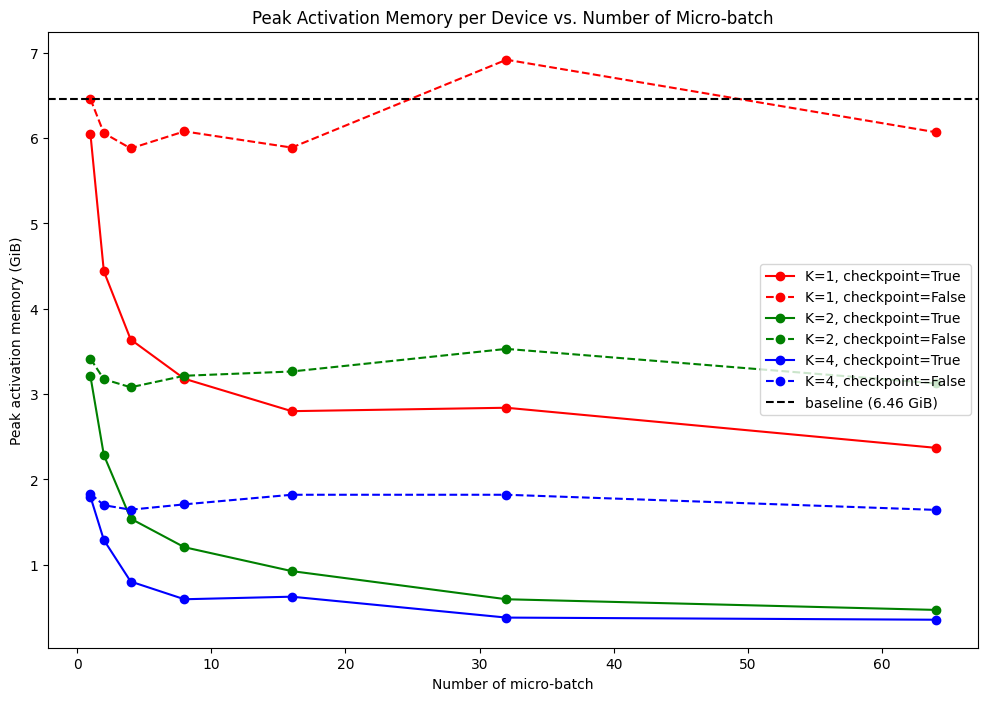

In [5]:
# Data from self-implemented GPipe
colors = dict(zip(num_partitions, ['r', 'g', 'b']))
linestyles = dict(zip(checkpoint_enabled, ['-', '--']))

fig = plt.figure(figsize=(12, 8))
for num_partition in num_partitions:
    for checkpoint in checkpoint_enabled:
        total_memories = []
        for num_micro_batch in num_micro_batches:
            expr_name = args_to_exprname(
                num_partition, num_micro_batch, checkpoint, use_torchgpipe=False, gpt_2=True
            )
            data = expr_data[expr_name]
            total_memories.append(data['peak_activation_memory_gib'] / num_partition)

        plt.plot(num_micro_batches, total_memories,
            color=colors[num_partition], linestyle=linestyles[checkpoint],
            label=f'K={num_partition}, checkpoint={checkpoint}',
            marker='o',
        )

plt.axhline(y=baseline['peak_activation_memory_gib'], 
            color='k', linestyle='--', 
            label=f'baseline ({baseline["peak_activation_memory_gib"]:.2f} GiB)')

plt.xlabel('Number of micro-batch')
plt.ylabel('Peak activation memory (GiB)')
plt.title('Peak Activation Memory per Device vs. Number of Micro-batch')
plt.legend()
plt.savefig(os.path.join(FIG_DIR, 'GPT2_PAMD.png'))
plt.show()

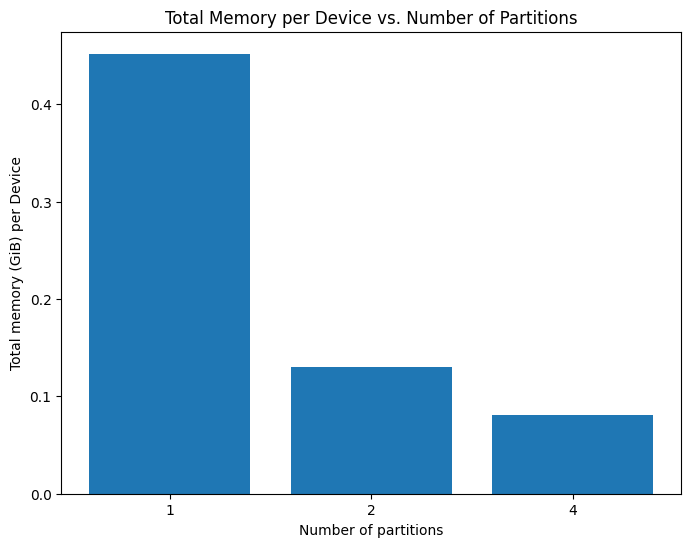

In [6]:
num_partitions = [1, 2, 4]
num_micro_batch = 64
checkpoint_enabled = True
baseline_mem = baseline['total_memory_gb']

total_memories = []
for num_partition in num_partitions:
    expr_name = args_to_exprname(
        num_partition, num_micro_batch, checkpoint_enabled, use_torchgpipe=False, gpt_2=True
    )
    total_memory = expr_data[expr_name]['total_memory_gb'] / num_partition / baseline_mem
    total_memories.append(total_memory)

# plot the total memory in a bar plot
plt.figure(figsize=(8, 6))
plt.bar([str(i) for i in num_partitions], total_memories)
plt.xlabel('Number of partitions')
plt.ylabel('Total memory (GiB) per Device')
plt.title('Total Memory per Device vs. Number of Partitions')
plt.savefig(os.path.join(FIG_DIR, 'GPT2_TMD.png'))
plt.show()

## Efficiency
- fixed: no checkpointing, architecture (`amoebanetd(num_classes=1000,  num_layers=18,  num_filters=256)`), 
- independent variables: number of partitions (n) and number of microbatches (m)
- dependent variables to observe: throughput speed-up rate compared to no parallelism

### Throughput
Measured by the throughput with maximum minibatch allowed by the memory

In [36]:
import pandas as pd

def create_throughput_table(data):
    # Extract unique num_partitions and num_micro_batches values
    num_partitions = set(int(key[1]) for key in data.keys())
    num_micro_batches = set(int(key[3:]) for key in data.keys())

    # Initialize an empty DataFrame
    df = pd.DataFrame(index=[f"M={m}" for m in sorted(num_micro_batches)], columns=[f"K={k}" for k in sorted(num_partitions)])

    # Baseline throughput for K=2, M=1
    baseline_throughput = float(data.get("n2m1", 0))

    # Fill in the DataFrame with speed-up rates
    for key, throughput in data.items():
        k = int(key[1])
        m = int(key[3:])
        speed_up_rate = round(float(throughput) / baseline_throughput, 3) if baseline_throughput else 0
        df.at[f"M={m}", f"K={k}"] = speed_up_rate

    return df

In [37]:
# Manually collected from results of command lines and sbatch logs
data = {
    "n2m1": "60.235",  # 155
    "n2m4": "70.571", # 480 
    "n2m32": "92.727", # 1500 
    "n4m1": "60.754", # 260 
    "n4m4": "105.034", # 600
    "n4m32": "151.624", # 980 
}

df = create_throughput_table(data)
df

,K=2,K=4
M=1,1.0,1.009
M=4,1.172,1.744
M=32,1.539,2.517
